### LorenzSystem

In [13]:
# include("utils/lorenzsystem.jl")
# include("tests/lorenzsystem-test.jl")

# test_lorenz_system()

### LorenzEnvironment()

In [14]:
# include("utils/lorenzenvironment.jl")
# include("tests/lorenzenvironment-test.jl")

# test_lorenz_environment()

### Scaler

In [15]:
# include("utils/scaler.jl")
# include("tests/scaler-test.jl")

# test_buildscaler_lorenz()

### Agent Training Loop

Importing utils...
Done importing. Starting run...
Expected number of steps per episode: 256
Building scaler...


Scaler built!

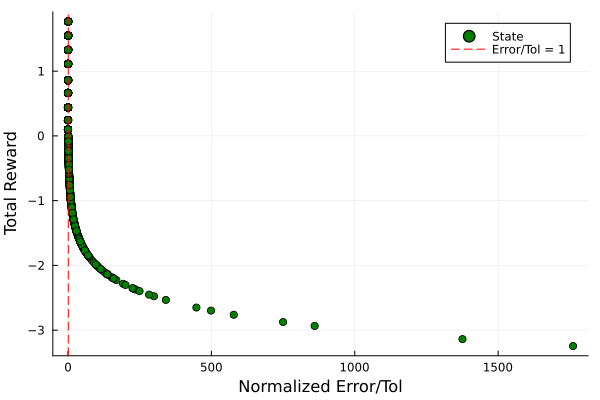


Episode 1 | Global Step 349 | Total Reward 148.93114120202435 | Avg Reward 0.4267367942751414 | Avg Error/TOL 3.496927793789447


Episode 2 | Global Step 651 | Total Reward 197.39808023602353 | Avg Reward 0.6536360272716011 | Avg Error/TOL 0.8372547729663854


Episode 3 | Global Step 941 | Total Reward 222.1550296817639 | Avg Reward 0.766051826488841 | Avg Error/TOL 0.3212269725503379


Episode 4 | Global Step 1232 | Total Reward 213.66424276939202 | Avg Reward 0.7342413840872578 | Avg Error/TOL 0.4118326108784416


Episode 5 | Global Step 1530 | Total Reward 208.71467718693367 | Avg Reward 0.7003848227749452 | Avg Error/TOL 0.37214008183960234


Episode 6 | Global Step 1818 | Total Reward 223.07702039216625 | Avg Reward 0.7745729874727995 | Avg Error/TOL 0.3735047414758495


Episode 7 | Global Step 2124 | Total Reward 217.4420483787706 | Avg Reward 0.7105949293423877 | Avg Error/TOL 0.25507460716640845


Episode 8 | Global Step 2435 | Total Reward 197.4800422376001 | Avg Reward 0.634984058641801 | Avg Error/TOL 0.3694789926362105


Episode 9 | Global Step 2732 | Total Reward 204.84478883336925 | Avg Reward 0.689713093715048 | Avg Error/TOL 0.4646629799459506


Episode 10 | Global Step 3022 | Total Reward 210.55959970493493 | Avg Reward 0.7260675851894308 | Avg Error/TOL 0.36528983505275586

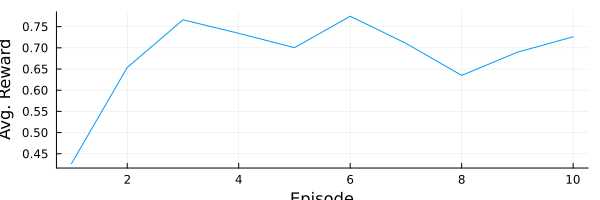

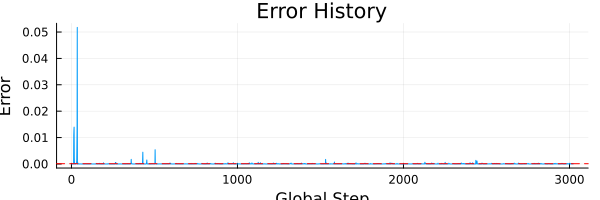

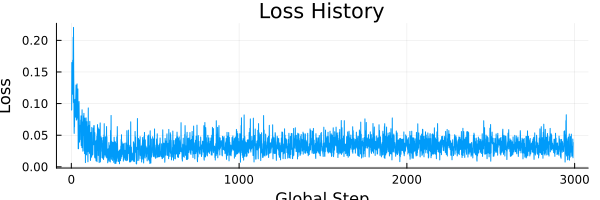

In [16]:
println("Importing utils...")

using Flux
using Random
include("utils/lorenzsystem.jl")
include("utils/lorenzenvironment.jl")
include("utils/scaler.jl")
include("utils/agent.jl")

println("Done importing. Starting run...")

# Define constants
N_EPISODES = 10
MAX_TIME = 10.0
MEMORY_SIZE = 10000
METHOD = "RKDP"
ACTION_SPACE = [0.02, 0.022, 0.025, 0.029, 0.033, 0.039, 0.045, 0.052, 0.060, 0.070]
LOOKBACK = 5
TOL = 1e-4
POS_REWARD_RANGE = (0.1, 2.0)
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
GAMMA = 0
EPSILON = 0.5
UPDATE_FREQ = 1

# INITIAL_STATE = [10.0, 10.0, 10.0]
INITIAL_STATE = nothing

# Initialize environment and agent
env = buildLorenzEnvironment(ACTION_SPACE, TOL, POS_REWARD_RANGE, MAX_TIME, METHOD)
println("Expected number of steps per episode: ", Int(round(MAX_TIME / env.action_space[6])))
scaler = build_scaler_lorenz(env, 9, INITIAL_STATE)
agent = buildAgent(env, scaler, LOOKBACK, EPSILON, MEMORY_SIZE)
optimizer = Flux.setup(Flux.Adam(LEARNING_RATE), agent.layers)

# Train agent
reward_history = []
error_history = []
global_step = 0
for episode in 1:N_EPISODES
    # Reset environment
    observation = new_system!(env, INITIAL_STATE)
    episode_rewards = []
    episode_errors = []
    
    done = false
    while !done
        # Choose a random action
        action = act(agent, observation)
        # println("Action: ", action)

        # Take action
        next_observation, error, reward, done = env_step!(env, action)
        push!(episode_rewards, reward)
        push!(episode_errors, error)
        push!(error_history, error)

        # Store transition in memory
        remember!(agent, observation, action, reward, next_observation, done)

        # Do one backwards pass every UPDATE_FREQ steps
        if global_step > 0 && global_step % UPDATE_FREQ == 0
            # println("Taking one training step")
            train!(agent, BATCH_SIZE, optimizer, GAMMA)
        end

        # Update observation
        observation = next_observation

        # Update global step
        global_step += 1
    end

    # Update reward history with average reward for episode
    push!(reward_history, sum(episode_rewards) / length(episode_rewards))

    # Print progress
    println("Episode $episode | Global Step $global_step | Total Reward $(sum(episode_rewards)) | Avg Reward $(sum(episode_rewards) / length(episode_rewards)) | Avg Error/TOL $(sum(episode_errors) / length(episode_errors) / TOL)")
end

##########################################################################################
# Plot reward history
display(plot(1:N_EPISODES, reward_history, xlabel="Episode", ylabel="Avg. Reward", legend=false, size=(600, 200)))

# Plot error history
plot(1:global_step, error_history, title="Error History", xlabel="Global Step", ylabel="Error", legend=false, size=(600, 200))
display(hline!([TOL], linecolor=:red, linestyle=:dash, label="TOL"))

# Plot loss history
display(plot(1:length(agent.loss_history), agent.loss_history, title="Loss History", xlabel="Global Step", ylabel="Loss", legend=false, size=(600, 200)))

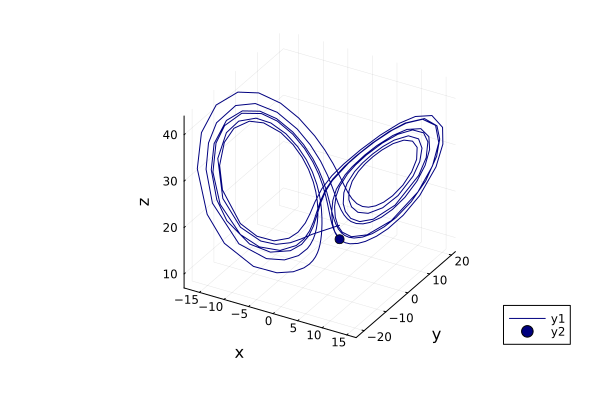

Number of systems in env: 10


In [17]:
# Plot predicted trajectory of last system over time

# plotlyjs() # Set the backend to PlotlyJS
println("Number of systems in env: ", length(agent.env.systems))
SYSTEM_IDX = length(agent.env.systems) - 1
plot_trajectory(agent.env.systems[SYSTEM_IDX])

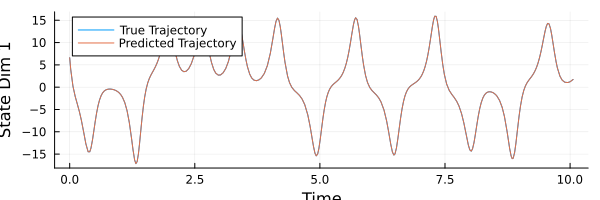

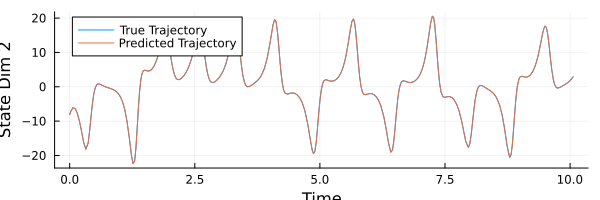

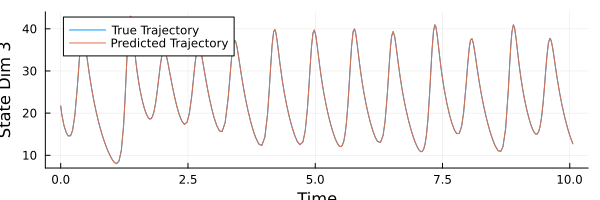

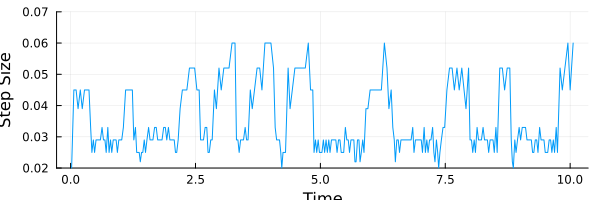

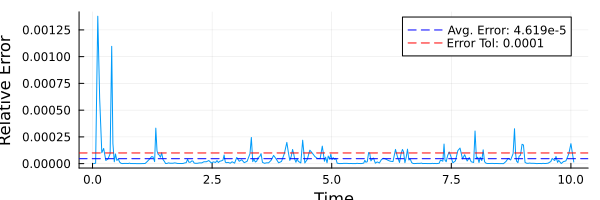

In [18]:
# Plot errors of last system over time
times = agent.env.systems[SYSTEM_IDX].time
true_trajectory = hcat(agent.env.systems[SYSTEM_IDX].true_state...)'
predicted_trajectory = hcat(agent.env.systems[SYSTEM_IDX].estimated_state...)'
timesteps = [times[i] - times[i-1] for i in 2:length(times)]
avg_errors = [norm(true_trajectory[i, :] - predicted_trajectory[i, :]) for i in 1:length(timesteps)]
avg_dim = size(true_trajectory)[2]

# Plot true trajectory vs predicted trajectory for each dimension
for i in 1:avg_dim
    plot(times, true_trajectory[:, i], xlabel="Time", ylabel="State Dim $(i)", legend=true, label="True Trajectory", size=(600, 200))
    display(plot!(times, predicted_trajectory[:, i], label="Predicted Trajectory"))
end

# Plot timesteps over time
plot(times[2:end], timesteps, xlabel="Time", ylabel="Step Size", legend=false, size=(600, 200))
display(ylims!(agent.env.action_space[1], agent.env.action_space[end]))

# Plot relative errors over time
plot(times[2:end], avg_errors, xlabel="Time", ylabel="Relative Error", legend=true, size=(600, 200), label=false)
hline!([mean(avg_errors)], linecolor=:blue, linestyle=:dash, label = "Avg. Error: $(round(mean(avg_errors), sigdigits = 4))")
# annotate!(times[2], mean(avg_errors)*2.5, text("Avg. State Error: $(mean(avg_errors))", :left, :top, 10, :blue))
display(hline!([TOL], linecolor=:red, linestyle=:dash, label = "Error Tol: $(TOL)"))


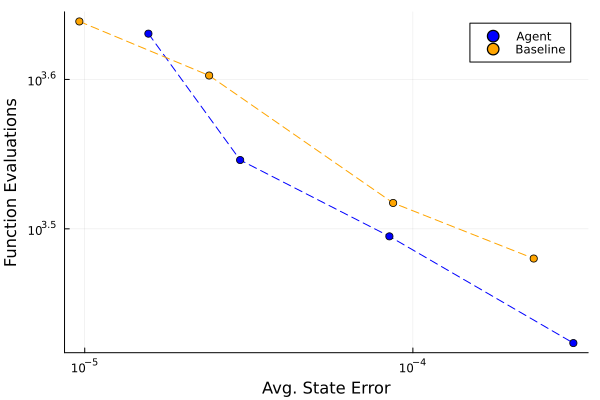

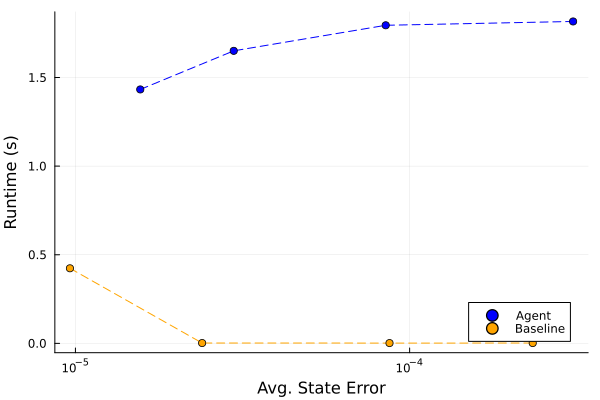

In [19]:
NEW_MAX_TIME = 2 * MAX_TIME

##########################################################################################
# Integrate with agent
new_env = buildLorenzEnvironment(ACTION_SPACE, TOL, POS_REWARD_RANGE, NEW_MAX_TIME, METHOD)
initial_state = [10.0, 10.0, 10.0]

avg_state_errors_agent = []
num_evals_agent = []
runtimes_agent = []
actions_agent = []
for step_boost in [-1, 0, 1, 2]
    # Run to collect stepwise error data
    observation = new_system!(new_env, initial_state)
    state_errors_agent = []
    done = false
    while !done
        action = act(agent, observation, eval_mode = true, step_boost = step_boost)
        next_observation, state_error, reward, done = env_step!(new_env, action)
        push!(actions_agent, ACTION_SPACE[action])
        push!(state_errors_agent, state_error)
        remember!(agent, observation, action, reward, next_observation, done)
        observation = next_observation
    end
    
    # Run again to collect runtime data
    observation = new_system!(new_env, initial_state)
    done = false
    start_time = time()
    while !done
        action = act(agent, observation, eval_mode = true, step_boost = step_boost)
        next_observation, done = env_step_evalmode!(new_env, action)
        push!(actions_agent, ACTION_SPACE[action])
        remember!(agent, observation, action, 0.0, next_observation, done)
        observation = next_observation
    end
    end_time = time()

    # Save data
    push!(runtimes_agent, end_time - start_time)
    push!(avg_state_errors_agent, sum(state_errors_agent) / length(state_errors_agent))
    push!(num_evals_agent, length(new_env.systems[end].eval_trace) * (length(new_env.systems[end].eval_trace[1].k)))
end
##########################################################################################
# Integrate with DP5 at different error tolerances
new_system!(new_env, initial_state)
tols = [5e-6, 1e-5, 2.5e-5, 5e-5]

avg_state_errors_baseline = []
num_evals_baseline = []
runtimes_baseline = []
for tol in tols
    # Integrate at desired tolerance
    start_time = time()
    ODEFunctionWrapper = (u, p, t) -> function_(t, u)
    prob = ODEProblem(ODEFunctionWrapper, new_env.systems[end].true_state[1], (0.0, NEW_MAX_TIME))
    predicted_sol = solve(prob, DP5(), reltol=tol, abstol=tol)
    end_time = time()
    
    # Collect stepwise error data
    state_errors_baseline = []
    for idx in 1:length(predicted_sol) - 1
        # Get ground truth state at next time step
        prob = ODEProblem(ODEFunctionWrapper, predicted_sol.u[idx, :][1], (predicted_sol.t[idx], predicted_sol.t[idx+1]))
        gt_sol = solve(prob, DP5(), reltol=1e-8)
        ground_truth = gt_sol.u[end]
        predicted = predicted_sol.u[idx+1]
        push!(state_errors_baseline, norm(ground_truth - predicted))
    end

    # Save data
    push!(runtimes_baseline, end_time - start_time)
    push!(num_evals_baseline, predicted_sol.destats.nf)
    push!(avg_state_errors_baseline, sum(state_errors_baseline) / length(state_errors_baseline))
end

##########################################################################################
# Plot function evaluations vs. state errors on a loglog plot
plot(avg_state_errors_agent, num_evals_agent, xlabel="Avg. State Error", ylabel="Function Evaluations", legend=true, xscale=:log10, yscale=:log10, label=false, color=:blue, linestyle=:dash)
plot!(avg_state_errors_baseline, num_evals_baseline, label=false, color=:orange, linestyle=:dash)
scatter!(avg_state_errors_agent, num_evals_agent, label="Agent", color=:blue)
display(scatter!(avg_state_errors_baseline, num_evals_baseline, label="Baseline", color=:orange))

# Plot runtime vs. state errors on a linlog plot
plot(avg_state_errors_agent, runtimes_agent, xlabel="Avg. State Error", ylabel="Runtime (s)", legend=true, xscale=:log10, label=false, color=:blue, linestyle=:dash)
plot!(avg_state_errors_baseline, runtimes_baseline, label=false, color=:orange, linestyle=:dash)
scatter!(avg_state_errors_agent, runtimes_agent, label="Agent", color=:blue)
display(scatter!(avg_state_errors_baseline, runtimes_baseline, label="Baseline", color=:orange))